In [1]:
import pandas as pd
import numpy as np
import datetime 

In [2]:
import statsmodels.formula.api as smf
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as pxy
import plotly.graph_objects as go
# from sklearn.metrics import r2_score, mean_squared_error
# import sklearn.metrics
# from sklearn.metrics import confusion_matrix, accuracy_score
# from sklearn.model_selection import train_test_split

# from scipy.stats import shapiro

In [3]:
pd.set_option('display.max_rows', 1000)
pd.options.display.max_columns = 1000

# "Let's get the mop?!" Data imports and cleaning

In [4]:
# dict_df['HubSpot Customer Base Metadata'].info()
# Cannot use xlrd package to read excel file because a critical number of rows are deleted. Expected 250k+, only received 65k+ 

In [17]:
hcm = pd.read_csv('C:/Users/shant/GNIZE/Study/HubSpot_Customer_Base_Metadata.csv', header=0)
hcv = pd.read_csv('C:/Users/shant/GNIZE/Study/HubSpot_Customer_Base_Value.csv', header=0) 
ie = pd.read_csv('C:/Users/shant/GNIZE/Study/Integration_Ecosystem.csv', header=0)

removing duplicates

In [18]:
hcm = hcm.drop_duplicates()
hcv = hcv.drop_duplicates()
ie = ie.drop_duplicates()

checking for null values

In [22]:
hcm.info()
#only dataset with null values. Product Tier contains customers with Undefined and null values. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274125 entries, 0 to 274126
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Customer ID             274125 non-null  int64 
 1   Report Month            274125 non-null  object
 2   Customer Employee Size  274125 non-null  object
 3   Product Tier            274125 non-null  object
 4   Customer Segment        274125 non-null  object
 5   Number of Integrations  274125 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 14.6+ MB


In [23]:
hcm.replace(np.NaN, 'Undefined', inplace=True)
#filling null values with Undefined. To be addressed after joining tables below

In [30]:
hcv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273984 entries, 0 to 274126
Data columns (total 5 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   Customer ID                        273984 non-null  int64 
 1   Report Month                       273984 non-null  object
 2   Customer Value Beginning of Month  273984 non-null  object
 3   Customer Value End of Month        273984 non-null  object
 4   Customer Cancellation Dollars      273984 non-null  object
dtypes: int64(1), object(4)
memory usage: 12.5+ MB


In [31]:
ie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32746 entries, 0 to 32745
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   Integration ID                            32746 non-null  int64 
 1   Report Month                              32746 non-null  object
 2   Integration Connect Partner? (Yes/No)     32746 non-null  object
 3   Paid Portal Installed Count               32746 non-null  int64 
 4   Free Portal Installed Count               32746 non-null  int64 
 5   Total Installed Count                     32746 non-null  int64 
 6   Integration Total MRR Beginning of Month  32746 non-null  object
 7   Integration Total MRR End of Month        32746 non-null  object
 8   Integration Total Cancellation Dollars    32746 non-null  object
dtypes: int64(4), object(5)
memory usage: 2.5+ MB


changing datatypes 

In [32]:
# hcm['Customer_ID'] = hcm['Customer_ID'].astype(str)
hcm['Report Month'] = pd.to_datetime(hcm['Report Month'], format='%Y-%m').dt.to_period('m')
hcv['Report Month'] = pd.to_datetime(hcv['Report Month'], format='%Y-%m').dt.to_period('m')
ie['Report Month'] = pd.to_datetime(ie['Report Month'], format='%Y-%m').dt.to_period('m')

In [33]:
def remove_dollar_and_commas_and_convert_to_float(value):
    if isinstance(value, str) and any(char.isdigit() for char in value):
        # Remove dollar sign and commas and convert to float
        value_cleaned = value.replace('$', '').replace(',', '')
        return float(value_cleaned)
    elif isinstance(value, (int, float)):
        return float(value)
    else:
        return value

In [34]:
hcv = hcv.applymap(remove_dollar_and_commas_and_convert_to_float)
ie = ie.applymap(remove_dollar_and_commas_and_convert_to_float)

new columns for anaysis

In [35]:
ie['Integration Total MRR Increase'] = ie['Integration Total MRR End of Month'].subtract(ie['Integration Total MRR Beginning of Month'])

In [36]:
check= ie[ie['Integration Total MRR Increase'] < 0]

In [37]:
check

,Integration ID,Report Month,Integration Connect Partner? (Yes/No),Paid Portal Installed Count,Free Portal Installed Count,Total Installed Count,Integration Total MRR Beginning of Month,Integration Total MRR End of Month,Integration Total Cancellation Dollars,Integration Total MRR Increase
104,105.0,2019-01,Yes,26.0,8.0,34.0,38092.0,37816.0,0.0,-276.0
117,118.0,2019-01,Yes,1882.0,943.0,2825.0,2824724.0,2812074.0,-42117.0,-12650.0
147,148.0,2019-01,No,1.0,1.0,2.0,900.0,875.0,0.0,-25.0
195,196.0,2019-01,No,2.0,0.0,2.0,9803.0,9556.0,0.0,-247.0
233,234.0,2019-01,No,81.0,29.0,110.0,164620.0,157350.0,-4964.0,-7270.0
...,...,...,...,...,...,...,...,...,...,...
32680,3400.0,2018-08,No,1.0,0.0,1.0,350.0,263.0,0.0,-87.0
32712,2201.0,2018-08,Yes,281.0,40.0,321.0,424663.0,422127.0,-100.0,-2536.0
32713,1954.0,2018-08,Yes,34.0,2.0,36.0,55586.0,54680.0,0.0,-906.0
32730,3019.0,2018-08,No,1.0,0.0,1.0,299.0,279.0,0.0,-20.0


# EDA

#### How have general integrations trended over time?

For customers, ICP and not, the Total Installation Count is on the rise

In [ ]:
ie.groupby(['Integration Connect Partner? (Yes/No)', 'Report Month']).agg({'Total Installed Count': ['sum','mean', 'min', 'max']})

In [ ]:
iot=ie.groupby(['Report Month','Integration Connect Partner? (Yes/No)'])['Total Installed Count','Integration Total Cancellation Dollars','Integration Total MRR Increase'].mean() 
iot.reset_index()

In [ ]:
ibm=ie.groupby(['Report Month'])['Paid Portal Installed Count','Free Portal Installed Count', 'Integration Total Cancellation Dollars'].mean() 
ibm.reset_index()

In [ ]:
ie['Integration Connect Partner? (Yes/No)'].value_counts()

Need to find a way to segment Integration ID based on Revenue, Cancellation dollars and number of installatons

"One and Done" 
"Above Average"
"Needle Movers" Large part of MRR but also cancellation

In [ ]:
ie['Total Installed Count'].mean()

In [ ]:
def weighted_average_of_group(values, weights, item):
    return (values * weights).groupby(item).sum() / weights.groupby(item).sum()

In [ ]:
hmm = weighted_average_of_group(values=ie['Integration Total Cancellation Dollars'],
                          weights=ie['Total Installed Count'], item=ie['Report Month'])
hmm.reset_index()

In [ ]:
hmm.head(1000)

In [ ]:
# ie.groupby(['Integration ID','Report Month'])['Total Installed Count','Integration Total Cancellation Dollars','Integration Total MRR Increase'].mean()

In [ ]:
pt= (hcm['Product Tier'].value_counts(normalize=True,dropna=False))*100

In [ ]:
pt = pt.reset_index()

In [ ]:
pt.columns = ['Product Tier','Distributions']

In [ ]:
a = hcm.groupby('Product Tier')['Number of Integrations'].sum()
a.reset_index()

In [ ]:
pta = pd.merge(pt, a, how="inner", on=['Product Tier'])
pta

In [ ]:
pta['Percentage of Intergrations']= (pta['Number of Integrations']/pta['Number of Integrations'].sum())*100

In [ ]:
pta

In [ ]:
(hcm.groupby('Product Tier')['Customer Segment'].value_counts(normalize=True,dropna=False))*100

In [ ]:
hcm.head(1000)

In [ ]:
hcv.groupby('Product Tier')['Customer Segment'].value_counts(normalize=True,dropna=False)

EDA wthin context.
In May 2018 hubspot launched the Apps for Agency program "25+ Integration Partners to Launch Free Software Program for Agencies"
Jan 2019 "HubSpot Launches Zoom Integration to Help Customers Have Better Meetings and Webinars"
looking back to know where we're going

In [ ]:
hscb = pd.merge(hcv, hcm, how="inner", on=['Customer ID','Report Month'])

In [ ]:
hscb.drop_duplicates()

In [ ]:
def replace_undefined(df):
    # Condition to check if 'Product_Tier' is 'Undefined' and corresponding Customer Subscription Value at the end of the month
    condition1 = (df['Product Tier'] == 'Undefined') &  (df['Customer Value End of Month'] <= 20)
    condition2 = (df['Product Tier'] == 'Undefined') &  (df['Customer Value End of Month'].between(21, 719))
    condition3 = (df['Product Tier'] == 'Undefined') & (df['Customer Value End of Month'].between(720, 2000))
    condition4 = (df['Product Tier'] == 'Undefined') & (df['Customer Value End of Month']>=2000)

    # Replace 'Product_Tier' values where the condition is True with value
    df.loc[condition1, 'Product Tier'] = 'Basic'
    df.loc[condition2, 'Product Tier'] = 'Starter'
    df.loc[condition3, 'Product Tier'] = 'Pro'
    df.loc[condition4, 'Product Tier'] = 'Enterprise'

    return df

In [ ]:
hcm = replace_undefined(hcm)

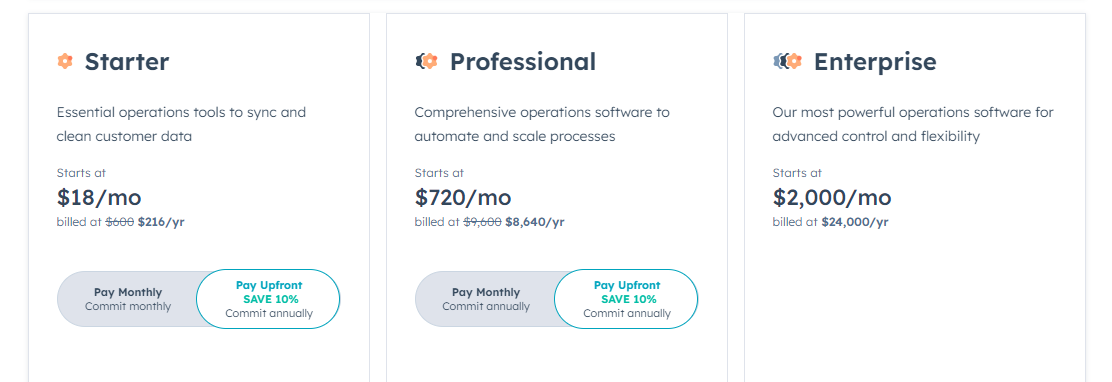

In [ ]:
hscb.info()

In [ ]:
hscb.reset_index()

In [ ]:
hcv = hcv.drop_duplicates()

In [ ]:
hcm= hcm.drop_duplicates()

In [ ]:
hcv.info()

Dont forget to measure the installion count increase from customer id start 